Loading data...
Data loaded successfully.
Generating strategy signals...
Signals generated.
Creating plot...


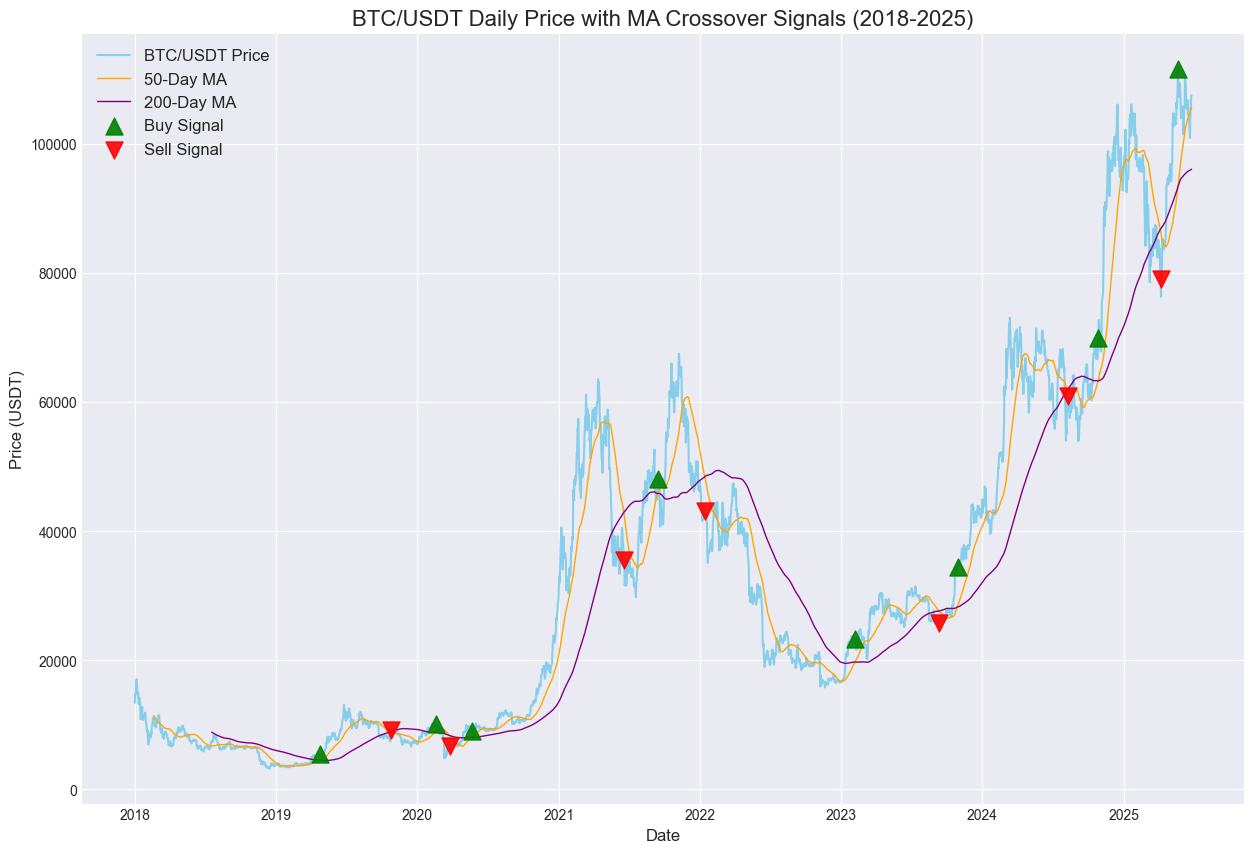


Plot displayed. Analysis complete.


In [8]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np

# Import our custom agents
from src.data.data_manager import DataManager
from src.strategies.ma_crossover_strategy import MovingAverageCrossoverStrategy
from src.regime.regime_filter import RegimeFilter

# Set a professional plot style
style.use('seaborn-v0_8-darkgrid')

# --- 1. Load Data ---
print("Loading data...")
data_manager = DataManager()
data = data_manager.load_data('data/BTC_USDT_1d.csv')
print("Data loaded successfully.")

# --- 2. Generate Strategy Signals ---
print("Generating strategy signals...")
# Use the same parameters as our baseline backtest
strategy = MovingAverageCrossoverStrategy(short_window=50, long_window=200)
signals = strategy.generate_signals(data)
print("Signals generated.")

# --- 3. Create the Plot ---
print("Creating plot...")
# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the closing price
ax.plot(data.index, data['close'], label='BTC/USDT Price', color='skyblue', linewidth=1.5)

# Plot the moving averages
ax.plot(signals.index, signals['short_ma'], label='50-Day MA', color='orange', linewidth=1)
ax.plot(signals.index, signals['long_ma'], label='200-Day MA', color='purple', linewidth=1)

# --- 4. Add Buy and Sell Markers ---

# Find the points where a buy signal occurred
buy_signals = signals[signals['signal'] == 1.0]
ax.scatter(buy_signals.index, data['close'][buy_signals.index], 
           label='Buy Signal', marker='^', color='green', s=150, alpha=0.9, zorder=5)

# Find the points where a sell signal occurred
sell_signals = signals[signals['signal'] == -1.0]
ax.scatter(sell_signals.index, data['close'][sell_signals.index], 
           label='Sell Signal', marker='v', color='red', s=150, alpha=0.9, zorder=5)


# --- 5. Finalize the Plot ---
ax.set_title('BTC/USDT Daily Price with MA Crossover Signals (2018-2025)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USDT)', fontsize=12)
ax.legend(fontsize=12)
plt.show()

print("\nPlot displayed. Analysis complete.")

Calculating RSI...
RSI calculation complete.

Applying RSI filter to signals...
Filter applied.

--- Signal Comparison ---
Original Buy Signals: 8
Filtered Buy Signals: 8 (Signals removed: 0)

Creating new comparison plot...


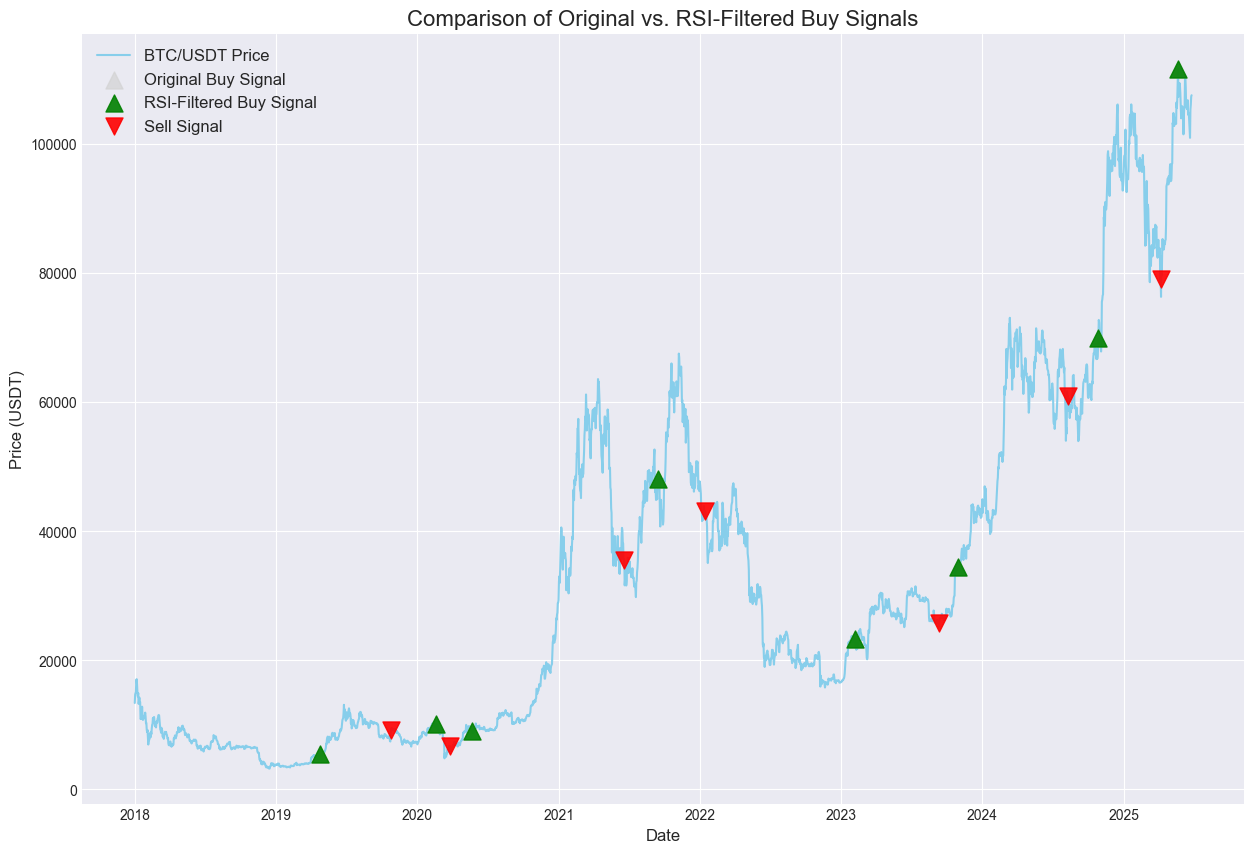

In [2]:
# --- 1. Calculate RSI ---
print("Calculating RSI...")
# Standard period for RSI is 14 days
rsi_period = 14

# Calculate price changes
delta = data['close'].diff()

# Separate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate the average gain and loss using an Exponentially Weighted Moving Average (EWMA)
avg_gain = gain.ewm(com=rsi_period - 1, min_periods=rsi_period).mean()
avg_loss = loss.ewm(com=rsi_period - 1, min_periods=rsi_period).mean()

# Calculate the Relative Strength (RS)
rs = avg_gain / avg_loss

# Calculate the RSI
data['rsi'] = 100 - (100 / (1 + rs))
print("RSI calculation complete.")


# --- 2. Apply the RSI Filter ---
print("\nApplying RSI filter to signals...")
# Create a new column for the filtered signals
signals['filtered_signal'] = signals['signal']

# Find all the buy signals from the original strategy
buy_signals_indices = signals[signals['signal'] == 1.0].index

# Check the RSI value on the day of each buy signal. 
# If RSI is not > 50, remove the buy signal.
for idx in buy_signals_indices:
    if data.loc[idx]['rsi'] <= 50:
        signals.loc[idx, 'filtered_signal'] = 0.0
print("Filter applied.")


# --- 3. Compare the Number of Signals ---
print("\n--- Signal Comparison ---")
original_buys = (signals['signal'] == 1.0).sum()
filtered_buys = (signals['filtered_signal'] == 1.0).sum()
print(f"Original Buy Signals: {original_buys}")
print(f"Filtered Buy Signals: {filtered_buys} (Signals removed: {original_buys - filtered_buys})")


# --- 4. Create the New Comparison Plot ---
print("\nCreating new comparison plot...")
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the closing price
ax.plot(data.index, data['close'], label='BTC/USDT Price', color='skyblue', linewidth=1.5, zorder=1)

# Plot the original, unfiltered buy signals as faint markers
ax.scatter(signals[signals['signal'] == 1.0].index, 
           data['close'][signals['signal'] == 1.0], 
           label='Original Buy Signal', marker='^', color='lightgray', s=150, alpha=0.7, zorder=2)

# Plot the new, RSI-filtered buy signals as bright, solid markers
ax.scatter(signals[signals['filtered_signal'] == 1.0].index, 
           data['close'][signals['filtered_signal'] == 1.0], 
           label='RSI-Filtered Buy Signal', marker='^', color='green', s=150, alpha=0.9, zorder=3)

# Plot the sell signals (we didn't filter these, but show them for context)
ax.scatter(signals[signals['signal'] == -1.0].index, 
           data['close'][signals['signal'] == -1.0], 
           label='Sell Signal', marker='v', color='red', s=150, alpha=0.9, zorder=3)

# Finalize the plot
ax.set_title('Comparison of Original vs. RSI-Filtered Buy Signals', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USDT)', fontsize=12)
ax.legend(fontsize=12)
plt.show()

Applying new 'Overbought' (RSI > 70) filter...
Filter applied.

--- Signal Comparison (Overbought Filter) ---
Original Buy Signals: 8
Filtered Buy Signals (RSI > 70 rejected): 5 (Signals removed: 3)

Creating new comparison plot...


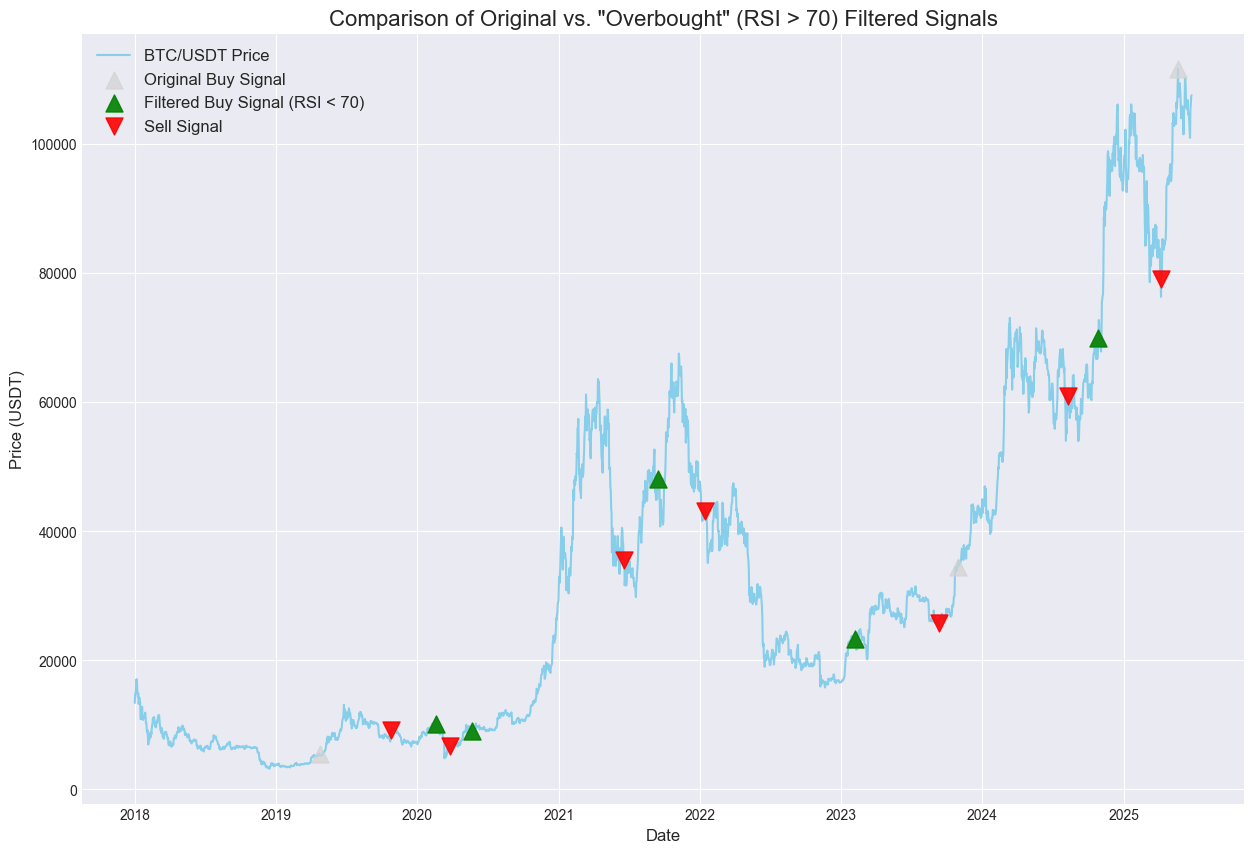

In [3]:
# --- 1. Define the New "Overbought" Filter ---
print("Applying new 'Overbought' (RSI > 70) filter...")
overbought_threshold = 70

# Create a new column for this second filtered signal
signals['overbought_filtered_signal'] = signals['signal']

# Get the original buy signals
buy_signals_indices = signals[signals['signal'] == 1.0].index

# This time, set the signal to 0 if the RSI is ABOVE the threshold
for idx in buy_signals_indices:
    if data.loc[idx]['rsi'] > overbought_threshold:
        signals.loc[idx, 'overbought_filtered_signal'] = 0.0
print("Filter applied.")


# --- 2. Compare the Number of Signals ---
print("\n--- Signal Comparison (Overbought Filter) ---")
original_buys = (signals['signal'] == 1.0).sum()
filtered_buys_new = (signals['overbought_filtered_signal'] == 1.0).sum()
print(f"Original Buy Signals: {original_buys}")
print(f"Filtered Buy Signals (RSI > 70 rejected): {filtered_buys_new} (Signals removed: {original_buys - filtered_buys_new})")


# --- 3. Create the New Comparison Plot ---
print("\nCreating new comparison plot...")
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the closing price
ax.plot(data.index, data['close'], label='BTC/USDT Price', color='skyblue', linewidth=1.5, zorder=1)

# Plot the original signals as faint markers
ax.scatter(signals[signals['signal'] == 1.0].index, 
           data['close'][signals['signal'] == 1.0], 
           label='Original Buy Signal', marker='^', color='lightgray', s=150, alpha=0.7, zorder=2)

# Plot the new, overbought-filtered buy signals
ax.scatter(signals[signals['overbought_filtered_signal'] == 1.0].index, 
           data['close'][signals['overbought_filtered_signal'] == 1.0], 
           label='Filtered Buy Signal (RSI < 70)', marker='^', color='green', s=150, alpha=0.9, zorder=3)

# Plot the sell signals
ax.scatter(signals[signals['signal'] == -1.0].index, 
           data['close'][signals['signal'] == -1.0], 
           label='Sell Signal', marker='v', color='red', s=150, alpha=0.9, zorder=3)

# Finalize the plot
ax.set_title('Comparison of Original vs. "Overbought" (RSI > 70) Filtered Signals', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USDT)', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [4]:
# --- Forensic Analysis of the 2023 Golden Cross ---
print("Conducting forensic analysis on the 2023 bull market entry signal...")

# Isolate the relevant timeframe
analysis_df = signals['2022-10-01':'2023-06-01'].copy()
analysis_df['rsi'] = data['rsi'] # Add RSI data for this period

# Find the first signal of a golden cross (where position flips from 0 to 1)
potential_signals = analysis_df[analysis_df['position'].diff() == 1.0]

if not potential_signals.empty:
    # Get the exact date of the first signal
    first_signal_date = potential_signals.index[0]
    
    # Get the RSI value on that specific day
    rsi_on_signal_date = analysis_df.loc[first_signal_date]['rsi']
    
    print("\n--- Forensic Results ---")
    print(f"The first 'Golden Cross' buy signal occurred on: {first_signal_date.date()}")
    print(f"The RSI value on that day was: {rsi_on_signal_date:.2f}")
    
    if rsi_on_signal_date > 70:
        print("\nCONCLUSION: The signal was REJECTED by our 'RSI > 70' filter.")
        print("This confirms the hypothesis that our filter caused the strategy to miss the 2023 rally.")
    else:
        print("\nCONCLUSION: The signal would NOT have been rejected by the RSI filter.")
        print("This implies a different, deeper issue with the strategy's logic or data.")
else:
    print("\n--- Forensic Results ---")
    print("No Golden Cross signal was found in the specified 2023 period.")

Conducting forensic analysis on the 2023 bull market entry signal...

--- Forensic Results ---
The first 'Golden Cross' buy signal occurred on: 2023-02-07
The RSI value on that day was: 63.95

CONCLUSION: The signal would NOT have been rejected by the RSI filter.
This implies a different, deeper issue with the strategy's logic or data.


Simulating new strategy: Enter on Golden Cross, Exit on Bear Regime...

Creating final comparison plot...


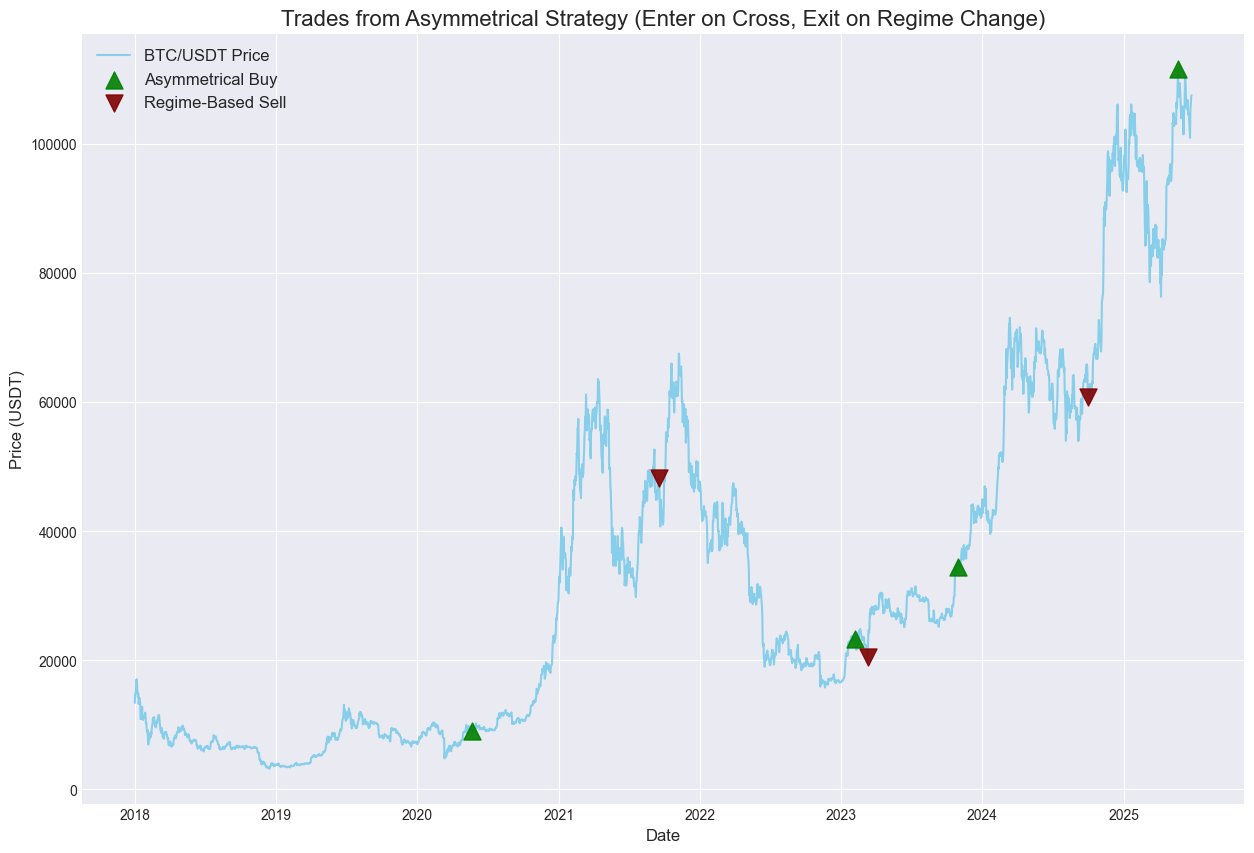

In [10]:
# --- Simulate a New Strategy with Asymmetrical Exit Logic (CORRECTED) ---
print("Simulating new strategy: Enter on Golden Cross, Exit on Bear Regime...")

# 1. Get the regime for each day using our simple MA-slope filter
# (This logic remains the same)
regime_filter = RegimeFilter(lookback_period=200)
data['regime'] = 'neutral'
ma = data['close'].rolling(window=regime_filter.lookback_period).mean()
ma_slope = ma.rolling(window=30).apply(lambda x: np.polyfit(range(30), x, 1)[0], raw=False)
data.loc[ma_slope > 0, 'regime'] = 'bull'
data.loc[ma_slope <= 0, 'regime'] = 'bear'


# 2. Generate the new position based on our new rules
# CORRECTED: Initialize the Series as empty (NaN) instead of with zeros.
new_position = pd.Series(index=signals.index, dtype=float)

# Get original buy signals
buy_dates = signals[signals['signal'] == 1.0].index

# Set position to 1 (long) on buy dates
new_position.loc[buy_dates] = 1.0

# Set position to 0 (flat) on any day the regime flips to 'bear'
new_position.loc[data['regime'] == 'bear'] = 0.0

# Forward-fill the position. This now works correctly.
new_position.ffill(inplace=True)
# Fill any remaining NaNs at the beginning with 0
new_position.fillna(0, inplace=True)


# 3. Determine the final trades based on this new position logic
final_trades = new_position.diff()


# 4. Create the final comparison plot
print("\nCreating final comparison plot...")
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(data.index, data['close'], label='BTC/USDT Price', color='skyblue', linewidth=1.5, zorder=1)

# Plot the new, improved trade signals
ax.scatter(final_trades[final_trades == 1.0].index, 
           data['close'][final_trades == 1.0], 
           label='Asymmetrical Buy', marker='^', color='green', s=150, alpha=0.9, zorder=3)

ax.scatter(final_trades[final_trades == -1.0].index, 
           data['close'][final_trades == -1.0], 
           label='Regime-Based Sell', marker='v', color='maroon', s=150, alpha=0.9, zorder=3)

# Finalize the plot
ax.set_title('Trades from Asymmetrical Strategy (Enter on Cross, Exit on Regime Change)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USDT)', fontsize=12)
ax.legend(fontsize=12)
plt.show()

Simulating a faster EMA Crossover Strategy...

Creating plot for EMA Crossover Strategy...


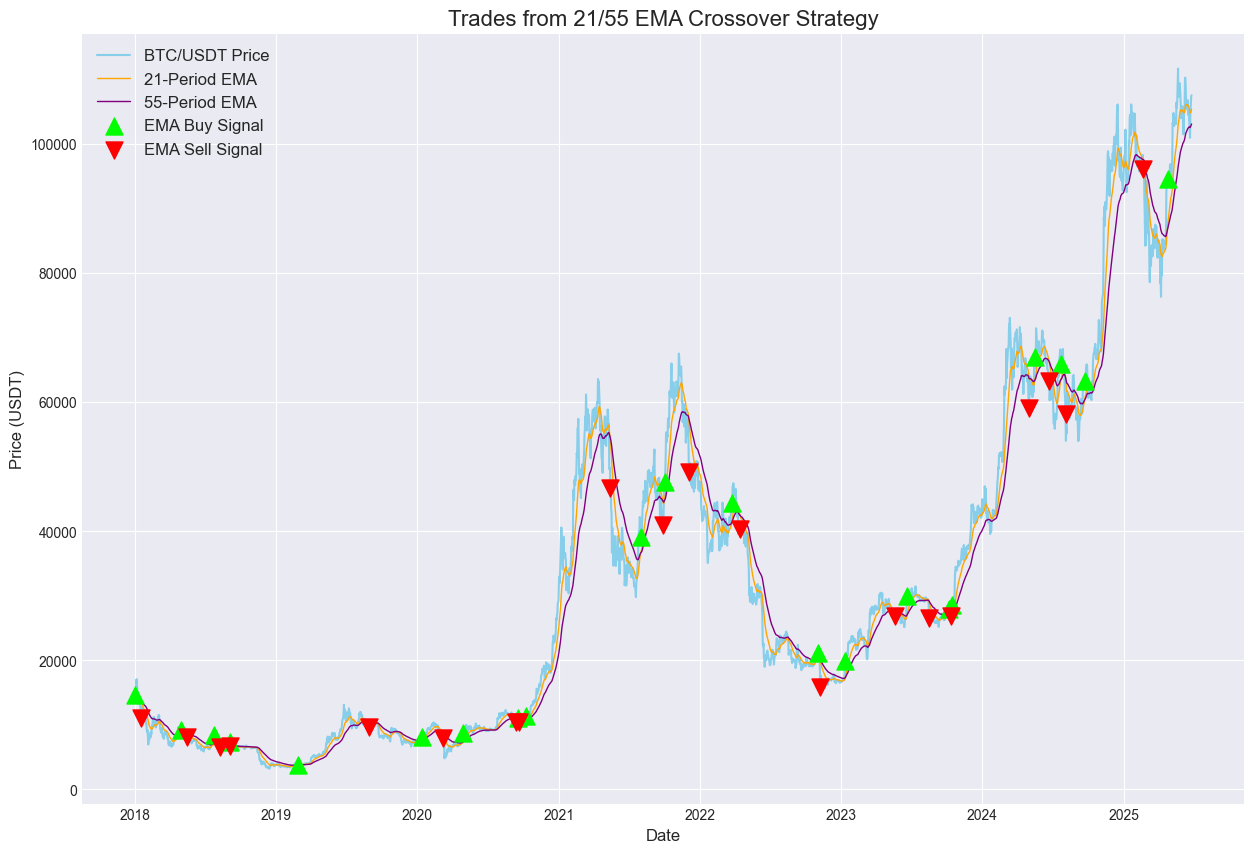

In [11]:
# --- Researching a Faster Strategy: EMA Crossover ---
print("Simulating a faster EMA Crossover Strategy...")

# 1. Define EMA periods
short_ema_period = 21
long_ema_period = 55

# 2. Calculate the Exponential Moving Averages (EMAs)
data['ema_short'] = data['close'].ewm(span=short_ema_period, adjust=False).mean()
data['ema_long'] = data['close'].ewm(span=long_ema_period, adjust=False).mean()

# 3. Generate signals based on the EMA crossover
ema_signals = pd.DataFrame(index=data.index)
ema_signals['position'] = np.where(data['ema_short'] > data['ema_long'], 1.0, 0.0)
ema_signals['signal'] = ema_signals['position'].diff()


# 4. Create the plot for the new EMA strategy
print("\nCreating plot for EMA Crossover Strategy...")
fig, ax = plt.subplots(figsize=(15, 10))

# Plot price and the new EMAs
ax.plot(data.index, data['close'], label='BTC/USDT Price', color='skyblue', linewidth=1.5, zorder=1)
ax.plot(data.index, data['ema_short'], label=f'{short_ema_period}-Period EMA', color='orange', linewidth=1)
ax.plot(data.index, data['ema_long'], label=f'{long_ema_period}-Period EMA', color='purple', linewidth=1)

# Plot the new EMA-based buy and sell signals
ax.scatter(ema_signals[ema_signals['signal'] == 1.0].index, 
           data['close'][ema_signals['signal'] == 1.0], 
           label='EMA Buy Signal', marker='^', color='lime', s=150, alpha=1, zorder=3)

ax.scatter(ema_signals[ema_signals['signal'] == -1.0].index, 
           data['close'][ema_signals['signal'] == -1.0], 
           label='EMA Sell Signal', marker='v', color='red', s=150, alpha=1, zorder=3)

# Finalize the plot
ax.set_title(f'Trades from {short_ema_period}/{long_ema_period} EMA Crossover Strategy', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USDT)', fontsize=12)
ax.legend(fontsize=12)
plt.show()